In [2]:
import glob
import os
import random
import pandas as pd
import numpy as np
import librosa
import librosa.display
from scipy.signal import medfilt2d
from scipy.stats import pearsonr, mstats, scoreatpercentile
import scipy.ndimage 
from scipy.stats.mstats import mquantiles
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import floor
from collections import defaultdict

# Utility Functions

In [148]:
def generate_beats_and_meters(beats, sr, hop_length,tempo, duration, time_signature=4):
    """Generate beat and meter grids within the duration of a song."""
    first_beat_time = librosa.frames_to_time(beats[0], sr=sr, hop_length=hop_length)
    seconds_per_beat = 60.0 / tempo
    beats_per_meter = time_signature
    seconds_per_meter = seconds_per_beat * beats_per_meter
    beat_grid_forward = [first_beat_time + i * seconds_per_beat for i in range(int((duration - first_beat_time) / seconds_per_beat))]
    beat_grid_backward = [first_beat_time - i * seconds_per_beat for i in range(1, int(first_beat_time / seconds_per_beat) + 1)]
    beat_grid_backward.reverse()
    beat_grid = beat_grid_backward + beat_grid_forward
    meter_grid_forward = [first_beat_time + i * seconds_per_meter for i in range(int((duration - first_beat_time) / seconds_per_meter))]
    meter_grid_backward = [first_beat_time - i * seconds_per_meter for i in range(1, int(first_beat_time / seconds_per_meter) + 1)]
    meter_grid_backward.reverse()
    meter_grid = meter_grid_backward + meter_grid_forward

    return beat_grid, meter_grid

def calculate_ki_chroma(chromagram, sr, hop_length):
    """Calculate a key-invariant chromagram for a given audio waveform using KS key-finding algorithm."""
    chroma_vals = np.sum(chromagram, axis=1)
    maj_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    min_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    maj_corrs = np.correlate(chroma_vals, maj_profile, mode='same')
    min_corrs = np.correlate(chroma_vals, min_profile, mode='same')
    key_shift = np.argmax(np.concatenate((maj_corrs, min_corrs))) % 12
    return np.roll(chromagram, -key_shift, axis=0)


def apply_diagonal_median_filter(ssm, filter_length=5):
    """Apply a median filter diagonally across a self-similarity matrix (SSM)."""
    # Assuming ssm is square
    ssm_filtered = np.zeros_like(ssm)
    for d in range(-ssm.shape[0] + 1, ssm.shape[1]):
        diag = np.diagonal(ssm, offset=d)
        filtered_diag = scipy.ndimage.median_filter(diag, size=filter_length)
        if d >= 0:
            np.fill_diagonal(ssm_filtered[:,d:], filtered_diag)
        else:
            np.fill_diagonal(ssm_filtered[-d:,:], filtered_diag)
    return np.abs(ssm_filtered)


def find_repetitions(ssm, beat_grid_frames, min_length=16, max_length=128, p=0.1, ts=0.60):
    repetitions = {}
    for i in range(len(beat_grid_frames)):
        for length in range(min_length, max_length + 1, 4):
            for j in range(i + 1, len(beat_grid_frames)):  # Ensure j > i to avoid self-comparison
                if j - i < length:
                    continue
                # Extract the diagonal segment D_{i,j,l}
                Di_j_l = ssm[i:i+length, j:j+length].diagonal()
                quantile_value = scoreatpercentile(Di_j_l, p*100)
                if quantile_value > ts:
                    key = (i, length)
                    repetitions.setdefault(key, []).append((j, quantile_value))

    # Construct L, ensuring R_il sets with more than one j are included, and filter for best j score in case of overlap
    L = []
    for (i, l), js in repetitions.items():
        # Sort js by score to ensure the highest score is considered first
        sorted_js = sorted(js, key=lambda x: x[1], reverse=True)
        if len(sorted_js) > 1:
            # Include only the highest scoring j for each i, l pair
            best_j, best_score = sorted_js[0]
            L.append({'i': i, 'j': best_j, 'l': l, 'score': best_score})

    return L

def greedy_select_segments(L, total_frames, length_multiplier):
    """
    Apply a greedy selection algorithm on the list of repetition sets, prioritizing
    the sets based on l * score, and considering non-overlapping segments with higher scores
    that lie within the song's boundaries.

    Parameters:
    - L: List of dictionaries from find_repetitions, each containing 'i', 'j', 'l', and 'score'.
    - total_frames: The total number of frames in the song, ensuring selections are within song bounds.
    
    Returns:
    - A list of selected repetition sets based on the greedy algorithm, with considerations for non-overlapping segments.
    """
    # Sort L by l * score in descending order
    sorted_L = sorted(L, key=lambda x: ((x['l'] * length_multiplier) * x['score']), reverse=True)

    selected_segments = []
    covered_frames = set()

    for segment in sorted_L:
        segment_start_i = segment['i']
        segment_end_i = segment['i'] + segment['l']
        
        segment_start_j = segment['j']
        segment_end_j = segment['j'] + segment['l']
        
        # Ensure the segment lies within the song's boundaries
        if not (segment_end_i <= total_frames and segment_end_j <= total_frames):
            continue

        # Create spans for the current segment for both 'i' and 'j'
        segment_span_i = set(range(segment_start_i, segment_end_i))
        segment_span_j = set(range(segment_start_j, segment_end_j))
        
        # Check for overlap with already covered frames for both 'i' and 'j' spans
        if segment_span_i & covered_frames or segment_span_j & covered_frames:
            # If there's overlap with either span, continue to the next segment without adding it to the selection
            continue
        
        # If no overlap, select this segment
        selected_segments.append(segment)
        # Mark these frames as covered for both 'i' and 'j' spans
        covered_frames |= segment_span_i
        covered_frames |= segment_span_j

    return selected_segments

def greedy_max_coverage(L, total_frames, weight_multiplier=1):
    """
    Apply a greedy selection algorithm on the list of repetition sets, aiming to 
    maximize the number of frames covered by non-overlapping repeating segments, 
    while ensuring that the segment boundaries fit within the song length in frames.
    
    Parameters:
    - L: List of dictionaries from find_repetitions, each containing 'i', 'j', 'l', and 'score'.
    - total_frames: The total number of frames in the song.
    
    Returns:
    - A list of selected repetition sets based on the greedy algorithm, aiming to maximize frame coverage.
    """  
    # Sort the list by a composite key that gives more weight to length than to score
    sorted_L = sorted(L, key=lambda x: (x['l'] * weight_multiplier) * x['score'], reverse=True)

    selected_segments = []
    covered_frames = set()

    for segment in sorted_L:
        # Calculate the frame span of the current segment and ensure it's within song boundaries
        if segment['i'] + segment['l'] <= total_frames and segment['j'] + segment['l'] <= total_frames:
            i_span = set(range(segment['i'], segment['i'] + segment['l']))
            j_span = set(range(segment['j'], segment['j'] + segment['l']))

            # Ensure no overlap with already covered frames
            if not (i_span & covered_frames or j_span & covered_frames):
                selected_segments.append(segment)
                covered_frames |= i_span
                covered_frames |= j_span

    return selected_segments

def plot_repetitions(ssm_1, repeating_segments_1, ssm_2, repeating_segments_2, padding_correction=0, algo=""):
    """Plotting and comparing SSMs and greedy selection algorithms with labels on repeating segments."""
    fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

    # Minimum and maximum similarity scores for the shared color bar
    vmin = min(np.min(ssm_1), np.min(ssm_2))
    vmax = max(np.max(ssm_1), np.max(ssm_2))

    # Plot settings
    cmap = 'viridis'
    aspect = 'equal'
    origin = 'lower'

    # Function to plot each SSM and its repeating segments
    def plot_ssm(ax, ssm, repeating_segments):
        ax.imshow(ssm, aspect=aspect, origin=origin, cmap=cmap, vmin=vmin, vmax=vmax)
        for idx, segment in enumerate(repeating_segments):
            i, j, l, score = segment['i'], segment['j'], segment['l'], segment['score']
            i_corrected = max(i - padding_correction, 0)
            j_corrected = max(j - padding_correction, 0)

            # Draw rectangles
            rect_ij = patches.Rectangle((j_corrected, i_corrected), l, l, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect_ij)

            rect_ji = patches.Rectangle((i_corrected, j_corrected), l, l, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect_ji)

            # Add labels in the middle of the rectangles
            label_text = f"{score*100:.2f}% match ({l} beats)"
            ax.text(j_corrected + l/2, i_corrected + l/2, label_text, ha='center', va='center', color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
            ax.text(i_corrected + l/2, j_corrected + l/2, label_text, ha='center', va='center', color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

    # Plot the first SSM and its segments
    plot_ssm(axs[0], ssm_1, repeating_segments_1)
    axs[0].set_title('Median Filtered SSM')

    # Plot the second SSM and its segments
    plot_ssm(axs[1], ssm_2, repeating_segments_2)
    axs[1].set_title('Enhanced SSM')

    # Set the axis labels for the figure
    fig.text(0.5, 0.1, 'Time (beat frames)', ha='center')
    fig.text(0.1, 0.5, 'Time (beat frames)', va='center', rotation='vertical')
    
    # Set the main plot title based on the algo parameter
    if algo:
        fig.suptitle(f"{algo} Selection Results", fontsize=16, y=0.90)

    # Shared color bar for both subplots
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Similarity Score')

    plt.show()
    
def combine_segments(segments, total_length):
    # Initialize list for processed segments with pair numbers
    processed_segments = []
    for idx, seg in enumerate(segments):
        # Assign unique pair numbers starting from 1
        pair_number = idx + 1
        # Append both the segment and its mirror with their respective pair numbers
        processed_segments.extend([
            (seg['i'], seg['i'] + seg['l'], pair_number),
            (seg['j'], seg['j'] + seg['l'], pair_number)
        ])

    # Sort the processed segments by their starting point
    processed_segments.sort(key=lambda x: x[0])

    all_segments = []
    # Initialize last_end to track the end of the last segment added
    last_end = 0

    for start, end, pair_num in processed_segments:
        # Check for a gap between this segment and the last, marking it as non-pattern if found
        if start > last_end:
            all_segments.append((last_end, start, 0))  # Non-pattern segment
        # Update last_end if this segment extends beyond the current last_end
        if end > last_end:
            all_segments.append((start, end, pair_num))
            last_end = end

    # Append a final non-pattern segment if there's remaining space in the total_length
    if last_end < total_length:
        all_segments.append((last_end, total_length, 0))

    return all_segments

def plot_chromagram_with_segments(chroma_sync, segments, beat_grid_times, sr=12000, hop_length=128, title=""):
    fig, ax = plt.subplots(figsize=(15, 4))
    librosa.display.specshow(chroma_sync, sr=sr, y_axis='chroma', x_axis='time',
                             x_coords=beat_grid_times, ax=ax, hop_length=hop_length)
    ax.set_ylabel('Chroma')
    ax.set_title(f'Chromagram with {title} SSM Segmentation' if title else 'Beat-Synced, Key-invariant Chromagram with SSM Segmentation')
    
    # Plot the segment lines on the chromagram
    def plot_segment_lines(ax, segments):
        total_frames = chroma_sync.shape[1]
        for segment in segments:
            if segment[0] > 0:  # Ignore the very start of the song
                start_time = beat_grid_times[segment[0]]
                ax.axvline(x=start_time, color='w', linestyle='--', linewidth=3)
            if segment[1] < total_frames:  # Ignore the very end of the song
                end_time = beat_grid_times[min(segment[1], len(beat_grid_times) - 1)]
                ax.axvline(x=end_time, color='w', linestyle='--', linewidth=3)
    
    plot_segment_lines(ax, segments)
    
    plt.tight_layout()
    plt.show()

# Load Audio, Extract Features, and Create Beat-Synchronous Chromagram

In [4]:
SR = 12000 # Target sample rate chosen to be 1/4 of the original 48kHz.
HOP_LENGTH = 128    # Hop length for short-time Fourier transform. 
                    # 128 at 12kHz gives a similar frame rate to a hop length of 512 at 48kHz.

# Load a random song from the test set
file_pattern = '../data/audio_files/processed/*.mp3'
song_ids = [os.path.basename(f).split('.')[0] for f in glob.glob(file_pattern)]
random.seed(42)
random_song_id = random.choice(song_ids)
audio_file = f'../data/audio_files/processed/{random_song_id}.mp3'

# Load the audio and extract beat features
y, _ = librosa.load(audio_file, sr=SR)
y_harm, y_perc = librosa.effects.hpss(y) # Harmonic and percussive source separation 
onset_env = librosa.onset.onset_strength(y=y_perc, sr=SR, hop_length=HOP_LENGTH)
duration = librosa.get_duration(y=y, sr=SR)
frame_duration = len(onset_env)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=SR, hop_length=HOP_LENGTH)
beat_grid, meter_grid = generate_beats_and_meters(beats, SR, HOP_LENGTH, tempo, duration, time_signature=4)
beat_grid_frames = librosa.time_to_frames(beat_grid, sr=SR, hop_length=HOP_LENGTH)
meter_grid_frames = librosa.time_to_frames(meter_grid, sr=SR, hop_length=HOP_LENGTH)
quantized_beats = np.intersect1d(beat_grid_frames, meter_grid_frames)
beat_grid_frames = librosa.util.fix_frames(beat_grid_frames)

# Extract chromagram and sync with beats
chromagram = librosa.feature.chroma_cqt(y=y_harm, sr=SR, hop_length=HOP_LENGTH, bins_per_octave=24)
chroma = (chromagram - chromagram.min()) / (chromagram.max() - chromagram.min()) # Normalize chromagram
chroma_ki = calculate_ki_chroma(chroma, SR, HOP_LENGTH)
chroma_sync = librosa.util.sync(chroma_ki, beat_grid_frames, aggregate=np.median) # Sync chromagram with beats with median aggregation 

## Visualizing the beat-synced chromagrams

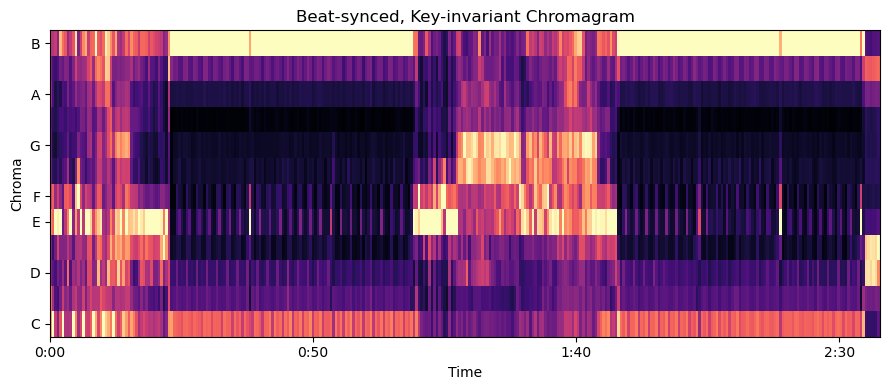

In [155]:
fig, ax = plt.subplots(figsize=(9, 4))
beat_grid_times = librosa.frames_to_time(beat_grid_frames, sr=SR, hop_length=HOP_LENGTH)
librosa.display.specshow(chroma_sync, sr=SR, y_axis='chroma', x_axis='time',
                         x_coords=beat_grid_times, ax=ax, hop_length=HOP_LENGTH)
ax.set_ylabel('Chroma')
ax.set_title('Beat-synced, Key-invariant Chromagram')

plt.tight_layout()
plt.show()

## Calculate SSM and Path Enhancement
- Transpose `chroma_sync` before computing pairwise distances to ensure that the resulting SSM is suitable for identifying repeating segments across time. The size of this SSM will be determined by the number of time frames (or beat-synced frames) in the chroma feature matrix.
- Calculate the SSM using Pearson correlation coefficients
- Take the absolute values of the SSM, scaling the values from [0, 1], making the SSM values more intuitively interpretable in terms of similarity (where 1 represents maximum similarity and 0 represents maximum dissimilarity, in the context of the normalized scale)
- Apply median filter to the normalized SSM
- Path enhancement is used to enhance continuity along diagonal paths in the SSM, which represent repeating musical segments. It's particularly useful for highlighting temporal structures and patterns that recur over time by making repeating paths more pronounced and easier to identify, especially in pieces with complex structures or subtle repetitions.
    - `librosa.segement.path_enhance()` is inspired by the multi-angle path enhancement of [1], but differs by modeling tempo differences in the space of similarity matrices rather than re-sampling the underlying features prior to generating the self-similarity matrix.

[1]
Müller, Meinard and Frank Kurth. “Enhancing similarity matrices for music audio analysis.” 2006 IEEE International Conference on Acoustics Speech and Signal Processing Proceedings. Vol. 5. IEEE, 2006.

In [22]:
chroma_sync_T = chroma_sync.T                 # Transpose chroma_sync to have time frames as rows for correlation calculation
ssm_pearson = abs(np.corrcoef(chroma_sync_T)) # Calculate the SSM using Pearson correlation coefficients

ssm_medfilt = apply_diagonal_median_filter(ssm_pearson, filter_length=5)
ssm_enhanced = librosa.segment.path_enhance(ssm_pearson, n=51, window='hann', n_filters=7, zero_mean=False, clip=True) 

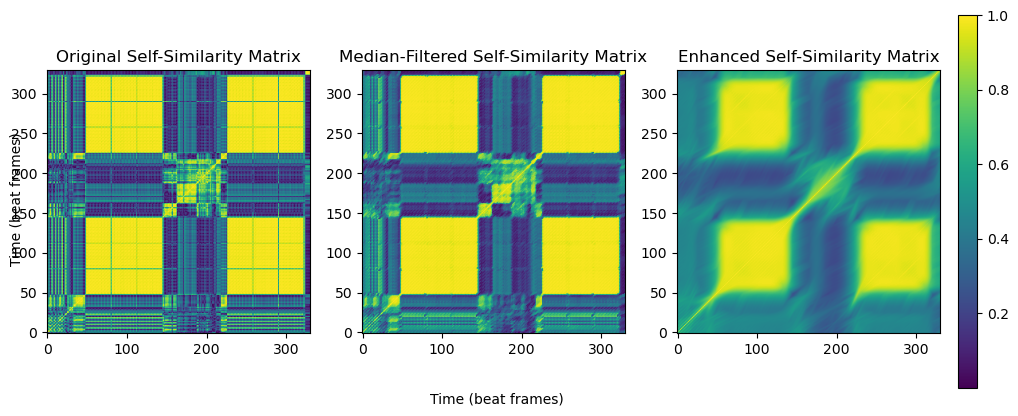

In [154]:
# Find global min and max for color normalization
vmin = min(np.min(ssm_pearson), np.min(ssm_medfilt), np.min(ssm_enhanced))
vmax = max(np.max(ssm_pearson), np.max(ssm_medfilt), np.max(ssm_enhanced))

fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex='all')

# Original SSM
img1 = ax[0].imshow(ssm_pearson, aspect='equal', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
ax[0].set_title('Original Self-Similarity Matrix')

# Filtered SSM
img2 = ax[1].imshow(ssm_medfilt, aspect='equal', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
ax[1].set_title('Median-Filtered Self-Similarity Matrix')

# Enhanced SSM
img3 = ax[2].imshow(ssm_enhanced, aspect='equal', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
ax[2].set_title('Enhanced Self-Similarity Matrix')

# Set shared labels for the entire figure
fig.text(0.5, 0.1, 'Time (beat frames)', ha='center', va='center')
fig.text(0.1, 0.5, 'Time (beat frames)', ha='center', va='center', rotation='vertical')

# Add a single color bar to the right of the plots
fig.colorbar(img3, ax=ax.ravel().tolist(), location='right', fraction=0.02, pad=0.02)

plt.show()

In [136]:
# Find repetitions for both median filtered and enhanced SSMs
repetitions_medfilt = find_repetitions(ssm_medfilt, beat_grid_frames, min_length=24, max_length=128, p=0.1, ts=0.60)
repetitions_enhanced = find_repetitions(ssm_enhanced, beat_grid_frames, min_length=24, max_length=128, p=0.1, ts=0.60)

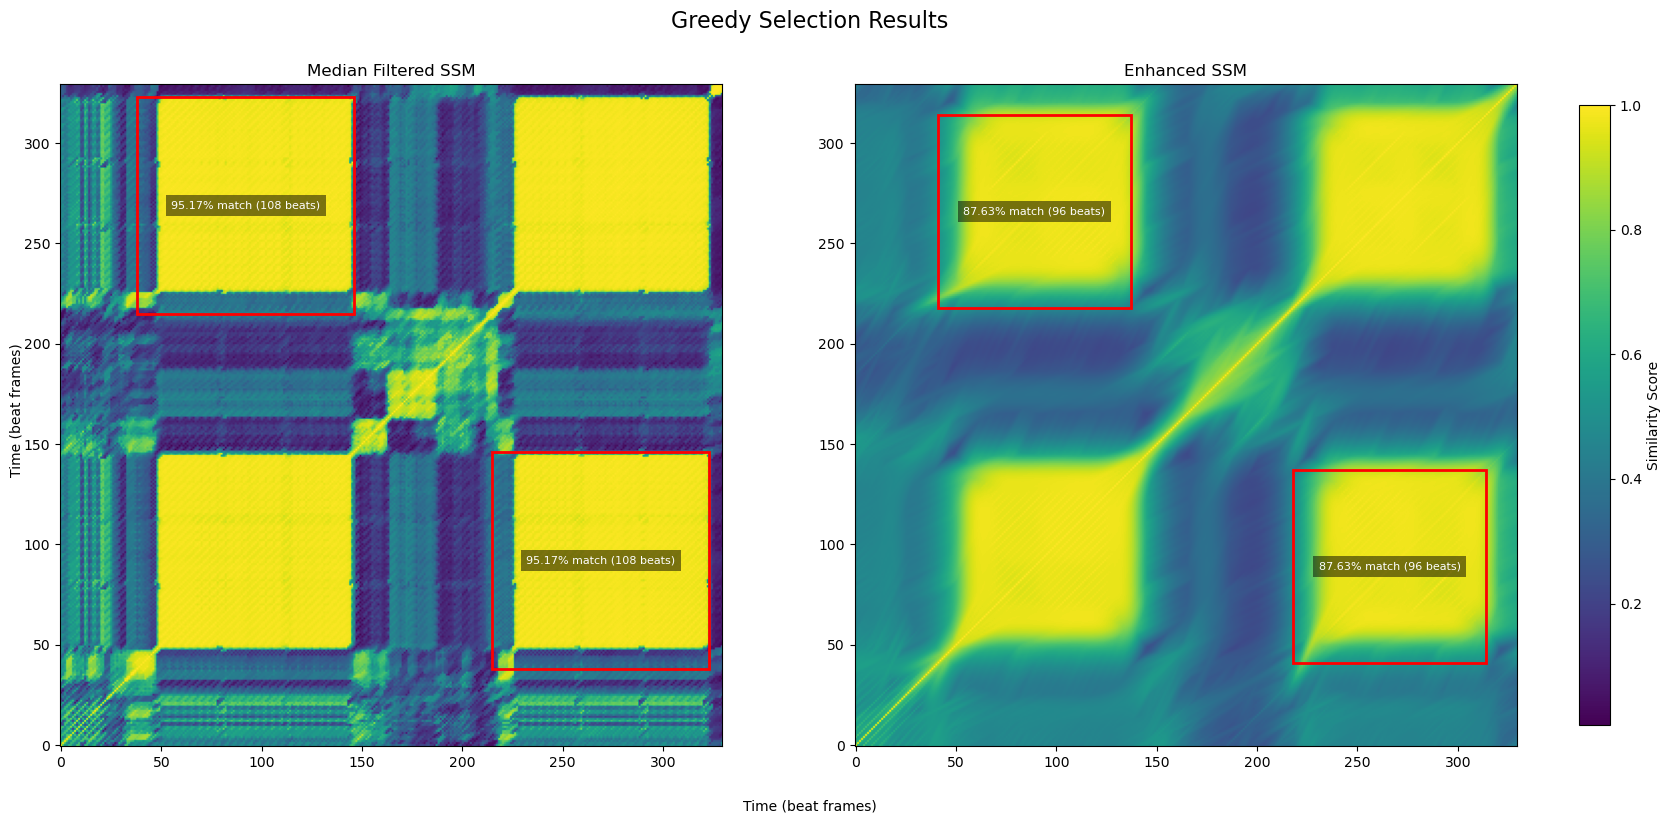

In [146]:
total_frames = ssm_medfilt.shape[0]
greedy_medfilt = greedy_select_segments(repetitions_medfilt, total_frames, length_multiplier=1)
greedy_enhanced = greedy_select_segments(repetitions_enhanced, total_frames, length_multiplier=1)
plot_repetitions(ssm_medfilt, greedy_medfilt, ssm_enhanced, greedy_enhanced, padding_correction=0, algo="Greedy")

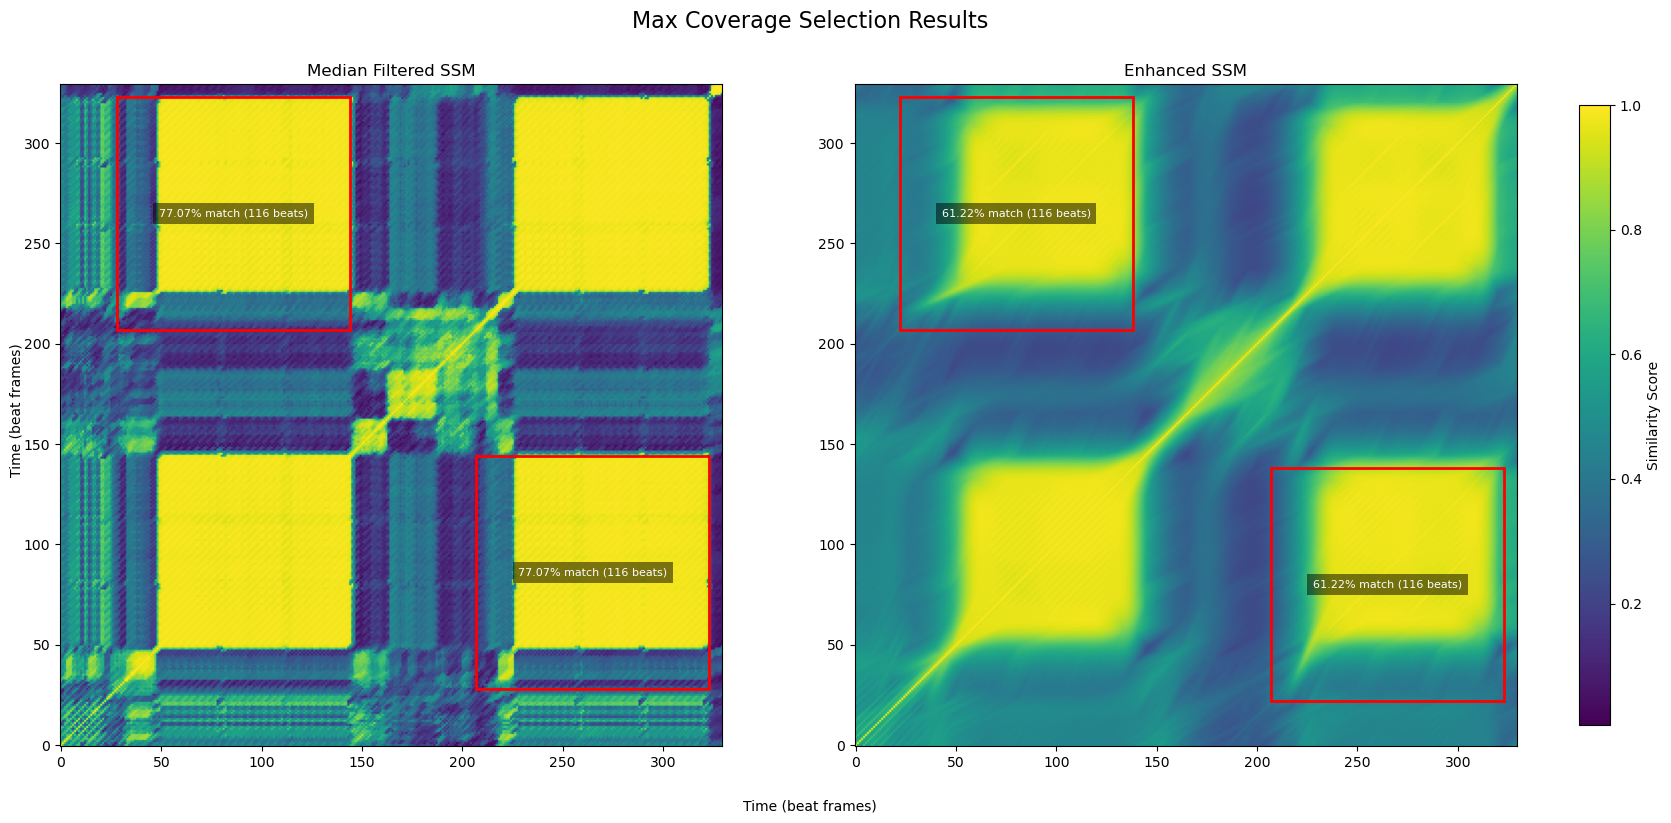

In [147]:
total_frames = ssm_medfilt.shape[0]
greedy_max_coverage_medfilt = greedy_select_max_coverage(repetitions_medfilt, total_frames)
greedy_max_coverage_enhanced = greedy_select_max_coverage(repetitions_enhanced, total_frames)
plot_repetitions(ssm_medfilt, greedy_max_coverage_medfilt, ssm_enhanced, greedy_max_coverage_enhanced, padding_correction=0, algo="Max Coverage")

In [149]:
segments_medfilt = combine_segments(greedy_medfilt, total_frames)
segments_enhanced = combine_segments(greedy_enhanced, total_frames)
segments_max_coverage_medfilt = combine_segments(greedy_max_coverage_medfilt, total_frames)
segments_max_coverage_enhanced = combine_segments(greedy_max_coverage_enhanced, total_frames)

In [150]:
segments_medfilt, segments_enhanced, segments_max_coverage_medfilt, segments_max_coverage_enhanced

([(0, 38, 0), (38, 146, 1), (146, 215, 0), (215, 323, 1), (323, 330, 0)],
 [(0, 41, 0), (41, 137, 1), (137, 218, 0), (218, 314, 1), (314, 330, 0)],
 [(0, 28, 0), (28, 144, 1), (144, 207, 0), (207, 323, 1), (323, 330, 0)],
 [(0, 22, 0), (22, 138, 1), (138, 207, 0), (207, 323, 1), (323, 330, 0)])

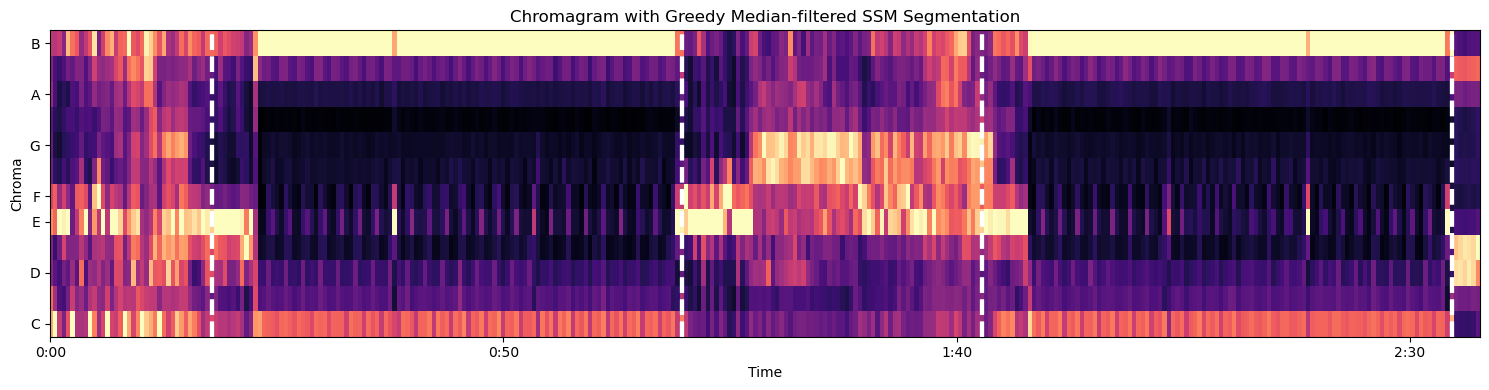

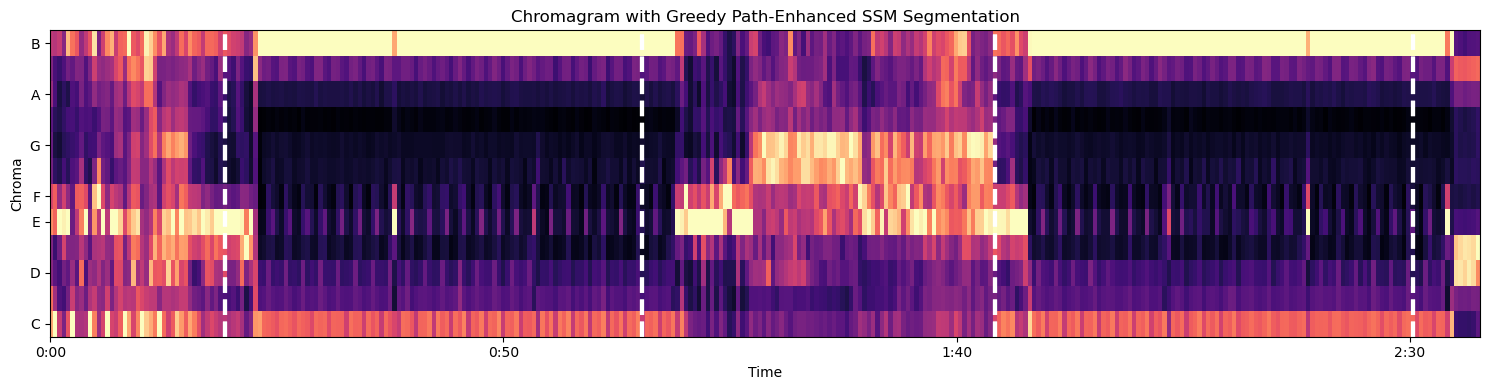

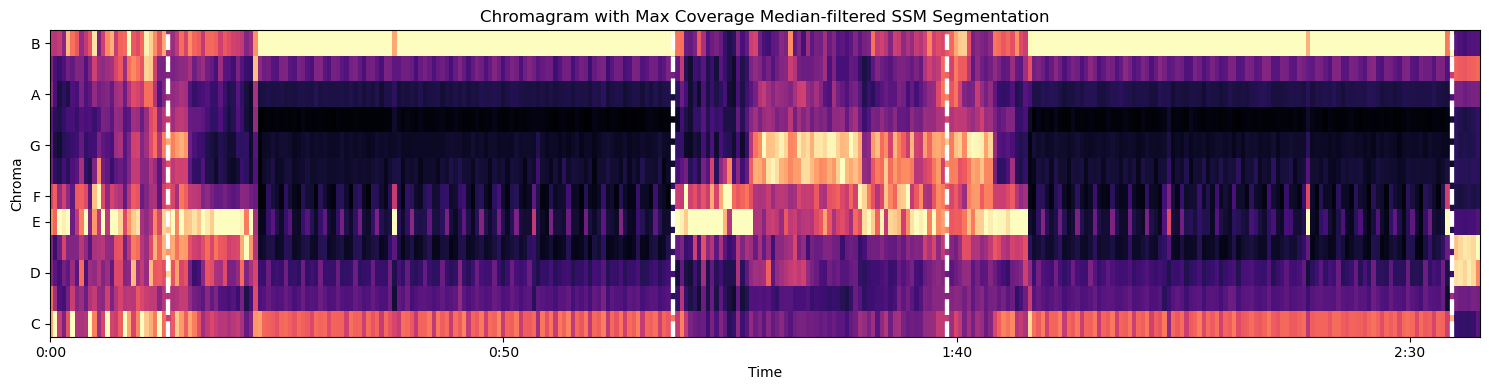

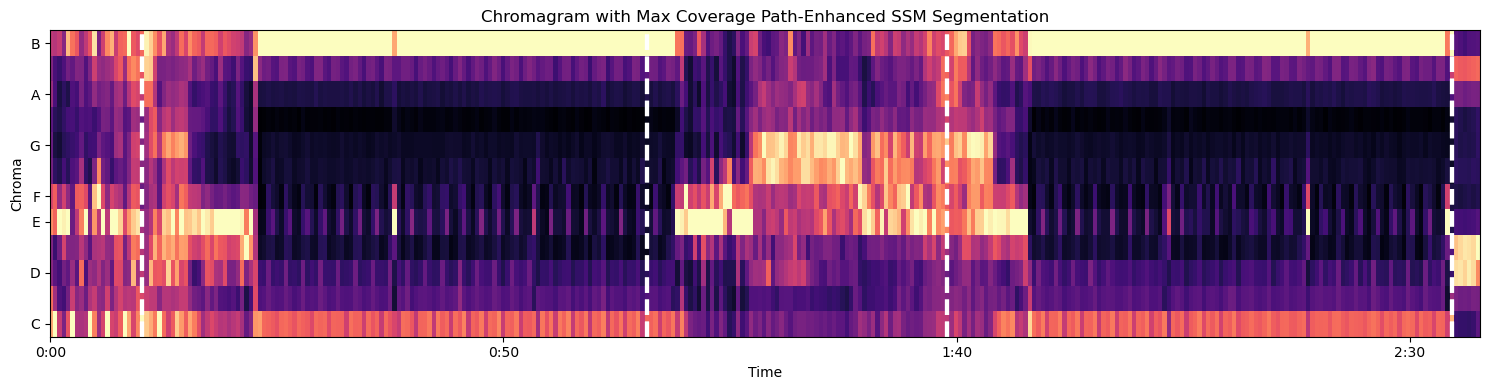

In [151]:
beat_grid_times = librosa.frames_to_time(beat_grid_frames, sr=SR, hop_length=HOP_LENGTH)
    
plot_chromagram_with_segments(chroma_sync, segments_medfilt, beat_grid_times, title="Greedy Median-filtered")
plot_chromagram_with_segments(chroma_sync, segments_enhanced, beat_grid_times, title="Greedy Path-Enhanced")
plot_chromagram_with_segments(chroma_sync, segments_max_coverage_medfilt, beat_grid_times, title="Max Coverage Median-filtered")
plot_chromagram_with_segments(chroma_sync, segments_max_coverage_enhanced, beat_grid_times, title="Max Coverage Path-Enhanced")